##### Copyright 2023 The MediaPipe Authors. All Rights Reserved.

In [13]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Gesture Recognizer with MediaPipe Tasks

This notebook shows you how to use MediaPipe Tasks Python API to recognize hand gestures in images.

## Preparation

Let's start with installing MediaPipe.

In [14]:
# !pip install -q mediapipe

Then download an off-the-shelf model. This model can recognize 7 hand gestures: 👍, 👎, ✌️, ☝️, ✊, 👋, 🤟

Check out the [MediaPipe documentation](https://developers.google.com/mediapipe/solutions/vision/gesture_recognizer#models) for more details about the model.

In [15]:
# !wget -q https://storage.googleapis.com/mediapipe-models/gesture_recognizer/gesture_recognizer/float16/1/gesture_recognizer.task

## Visualization Utilities

In [16]:
import math

import mediapipe as mp
#@markdown We implemented some functions to visualize the gesture recognition results. <br/> Run the following cell to activate the functions.
from matplotlib import pyplot as plt
from mediapipe.framework.formats import landmark_pb2

plt.rcParams.update({
    'axes.spines.top': False,
    'axes.spines.right': False,
    'axes.spines.left': False,
    'axes.spines.bottom': False,
    'xtick.labelbottom': False,
    'xtick.bottom': False,
    'ytick.labelleft': False,
    'ytick.left': False,
    'xtick.labeltop': False,
    'xtick.top': False,
    'ytick.labelright': False,
    'ytick.right': False
})

mp_hands = mp.solutions.hands
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles


def display_one_image(image, title, subplot, titlesize=16):
    """Displays one image along with the predicted category name and score."""
    plt.subplot(*subplot)
    plt.imshow(image)
    if len(title) > 0:
        plt.title(title, fontsize=int(titlesize), color='black', fontdict={'verticalalignment': 'center'},
                  pad=int(titlesize / 1.5))
    return subplot[0], subplot[1], subplot[2] + 1


def display_batch_of_images_with_gestures_and_hand_landmarks(images, results):
    """Displays a batch of images with the gesture category and its score along with the hand landmarks."""
    # Images and labels.
    images = [image.numpy_view() for image in images]
    gestures = [top_gesture for (top_gesture, _) in results]
    multi_hand_landmarks_list = [multi_hand_landmarks for (_, multi_hand_landmarks) in results]

    # Auto-squaring: this will drop data that does not fit into square or square-ish rectangle.
    rows = int(math.sqrt(len(images)))
    cols = len(images) // rows

    # Size and spacing.
    FIGSIZE = 13.0
    SPACING = 0.1
    subplot = (rows, cols, 1)
    if rows < cols:
        plt.figure(figsize=(FIGSIZE, FIGSIZE / cols * rows))
    else:
        plt.figure(figsize=(FIGSIZE / rows * cols, FIGSIZE))

    # Display gestures and hand landmarks.
    for i, (image, gestures) in enumerate(zip(images[:rows * cols], gestures[:rows * cols])):
        title = f"{gestures.category_name} ({gestures.score:.2f})"
        dynamic_titlesize = FIGSIZE * SPACING / max(rows, cols) * 40 + 3
        annotated_image = image.copy()

        for hand_landmarks in multi_hand_landmarks_list[i]:
            hand_landmarks_proto = landmark_pb2.NormalizedLandmarkList()
            hand_landmarks_proto.landmark.extend([
                landmark_pb2.NormalizedLandmark(x=landmark.x, y=landmark.y, z=landmark.z) for landmark in hand_landmarks
            ])

            mp_drawing.draw_landmarks(
                annotated_image,
                hand_landmarks_proto,
                mp_hands.HAND_CONNECTIONS,
                mp_drawing_styles.get_default_hand_landmarks_style(),
                mp_drawing_styles.get_default_hand_connections_style())

        subplot = display_one_image(annotated_image, title, subplot, titlesize=dynamic_titlesize)

    # Layout.
    plt.tight_layout()
    plt.subplots_adjust(wspace=SPACING, hspace=SPACING)
    plt.show()


def display_batch_of_images_undetected(images):
    images = [image.numpy_view() for image in images]

    rows = int(math.sqrt(len(images)))
    cols = len(images) // rows

    # Size and spacing.
    FIGSIZE = 13.0
    SPACING = 0.1
    subplot = (rows, cols, 1)
    if rows < cols:
        plt.figure(figsize=(FIGSIZE, FIGSIZE / cols * rows))
    else:
        plt.figure(figsize=(FIGSIZE / rows * cols, FIGSIZE))

    for i, image in enumerate(images[:rows * cols]):
        title = ""
        dynamic_titlesize = FIGSIZE * SPACING / max(rows, cols) * 40 + 3
        annotated_image = image.copy()
        subplot = display_one_image(annotated_image, title, subplot, titlesize=dynamic_titlesize)

    # Layout.
    plt.tight_layout()
    plt.subplots_adjust(wspace=SPACING, hspace=SPACING)
    plt.show()


Create undetected and wrong label log files (.json)

In [17]:
def create_log_file(data, filename: str):
    if not os.path.exists('./out/logs'):
        os.mkdir('./out/logs')
    with open(f'./out/logs/{filename}.json', 'w') as f:
        f.write(json.dumps(data))

## Download test images

Let's grab some test images that we'll use later. The images ([1](https://pixabay.com/photos/idea-pointing-raise-hand-raise-3082824/), [2](https://pixabay.com/photos/thumbs-up-happy-positive-woman-2649310/), [3](https://pixabay.com/photos/epidemic-disease-coronavirus-5082474/), [4](https://pixabay.com/photos/thumbs-down-disapprove-gesture-6744094/)) are from Pixabay.

In [18]:
# import urllib
# 
# IMAGE_FILENAMES = ['thumbs_down.jpg', 'victory.jpg', 'thumbs_up.jpg', 'pointing_up.jpg']
# 
# for name in IMAGE_FILENAMES:
#   url = f'https://storage.googleapis.com/mediapipe-tasks/gesture_recognizer/{name}'
#   urllib.request.urlretrieve(url, name)

Optionally, you can upload your own image. If you want to do so, uncomment and run the cell below.

In [19]:
# from google.colab import files
# uploaded = files.upload()
# 
# for filename in uploaded:
#   content = uploaded[filename]
#   with open(filename, 'wb') as f:
#     f.write(content)
# IMAGE_FILENAMES = list(uploaded.keys())
# 
# print('Uploaded files:', IMAGE_FILENAMES)

Generate data.json file to save path and labels

In [20]:
# generate image resource .json
import os
import json
import params

images = []

for lb, v in params.LABELS.items():
    if not os.path.exists(f'./data/new/{v}'):
        continue
    else:
        IMAGE_FILENAMES = []
        for _, _, files in os.walk(f'./data/new/{v}'):
            IMAGE_FILENAMES = files
        for filename in IMAGE_FILENAMES:
            image = {
                "filename": filename,
                "label": v
            }
            images.append(image)

with open('./data/data.json', 'w') as f:
    f.write(json.dumps(images))

Loading all images in dataset

In [21]:
import params
import json

# ROOT = os.path.dirname(__file__)
IMAGE_FILENAMES = []
with open('./data/data.json', 'r') as f:
    IMAGE_FILENAMES.extend(json.load(f))

print(IMAGE_FILENAMES)

[{'filename': 'Cam Bien So_Camera 01_20340103165137_731447.jpg', 'label': 0}, {'filename': 'Cam Bien So_Camera 01_20340103165210_764842.jpg', 'label': 0}, {'filename': 'Cam Bien So_Camera 01_20340104002558_1954116.jpg', 'label': 0}, {'filename': 'Cam Bien So_Camera 01_20340104002553_1948368.jpg', 'label': 0}, {'filename': 'Cam Bien So_Camera 01_20340104002954_2189530.jpg', 'label': 0}, {'filename': 'Cam Bien So_Camera 01_20340104002537_1932786.jpg', 'label': 0}, {'filename': 'Cam Bien So_Camera 01_20340104002932_2167887.jpg', 'label': 0}, {'filename': 'Cam Bien So_Camera 01_20340104002602_1957587.jpg', 'label': 0}, {'filename': 'Cam Bien So_Camera 01_20340103165157_751852.jpg', 'label': 1}, {'filename': 'Cam Bien So_Camera 01_20340104002404_1840232.jpg', 'label': 1}, {'filename': 'Cam Bien So_Camera 01_20340104002401_1836313.jpg', 'label': 1}, {'filename': 'Cam Bien So_Camera 01_20340104002514_1910203.jpg', 'label': 1}, {'filename': 'Cam Bien So_Camera 01_20340103165202_756412.jpg', 'l

Then let's check out the images.

In [22]:
# import cv2
# import math
# 
# DESIRED_HEIGHT = 480
# DESIRED_WIDTH = 480
# 
# 
# def resize_and_show(image):
#     h, w = image.shape[:2]
#     if h < w:
#         img = cv2.resize(image, (DESIRED_WIDTH, math.floor(h / (w / DESIRED_WIDTH))))
#     else:
#         img = cv2.resize(image, (math.floor(w / (h / DESIRED_HEIGHT)), DESIRED_HEIGHT))
#     cv2.imshow("window", img)
# 
# 
# # Preview the images.
# images = {
#     "name": cv2.imread(f"./data/new/{name['label']}/{name['filename']}") for name in IMAGE_FILENAMES
# }
# for name, image in images.items():
#     print(name)
#     resize_and_show(image)

## Running inference and visualizing the results

Here are the steps to run gesture recognizer using MediaPipe.

Check out the [MediaPipe documentation](https://developers.google.com/mediapipe/solutions/vision/gesture_recognizer/python) to learn more about configuration options that this solution supports.

*Note: Gesture Recognizer also returns the hand landmark it detects from the image, together with other useful information such as whether the hand(s) detected are left hand or right hand.*

In [23]:
# Total samples
total_images = len(IMAGE_FILENAMES)
print(total_images)

60


I0000 00:00:1710067858.681248 1051981 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1710067858.682217 1053332 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: Mesa Intel(R) Graphics (ADL-S GT1)
W0000 00:00:1710067858.682460 1051981 gesture_recognizer_graph.cc:129] Hand Gesture Recognizer contains CPU only ops. Sets HandGestureRecognizerGraph acceleration to Xnnpack.
I0000 00:00:1710067858.683031 1051981 hand_gesture_recognizer_graph.cc:250] Custom gesture classifier is not defined.


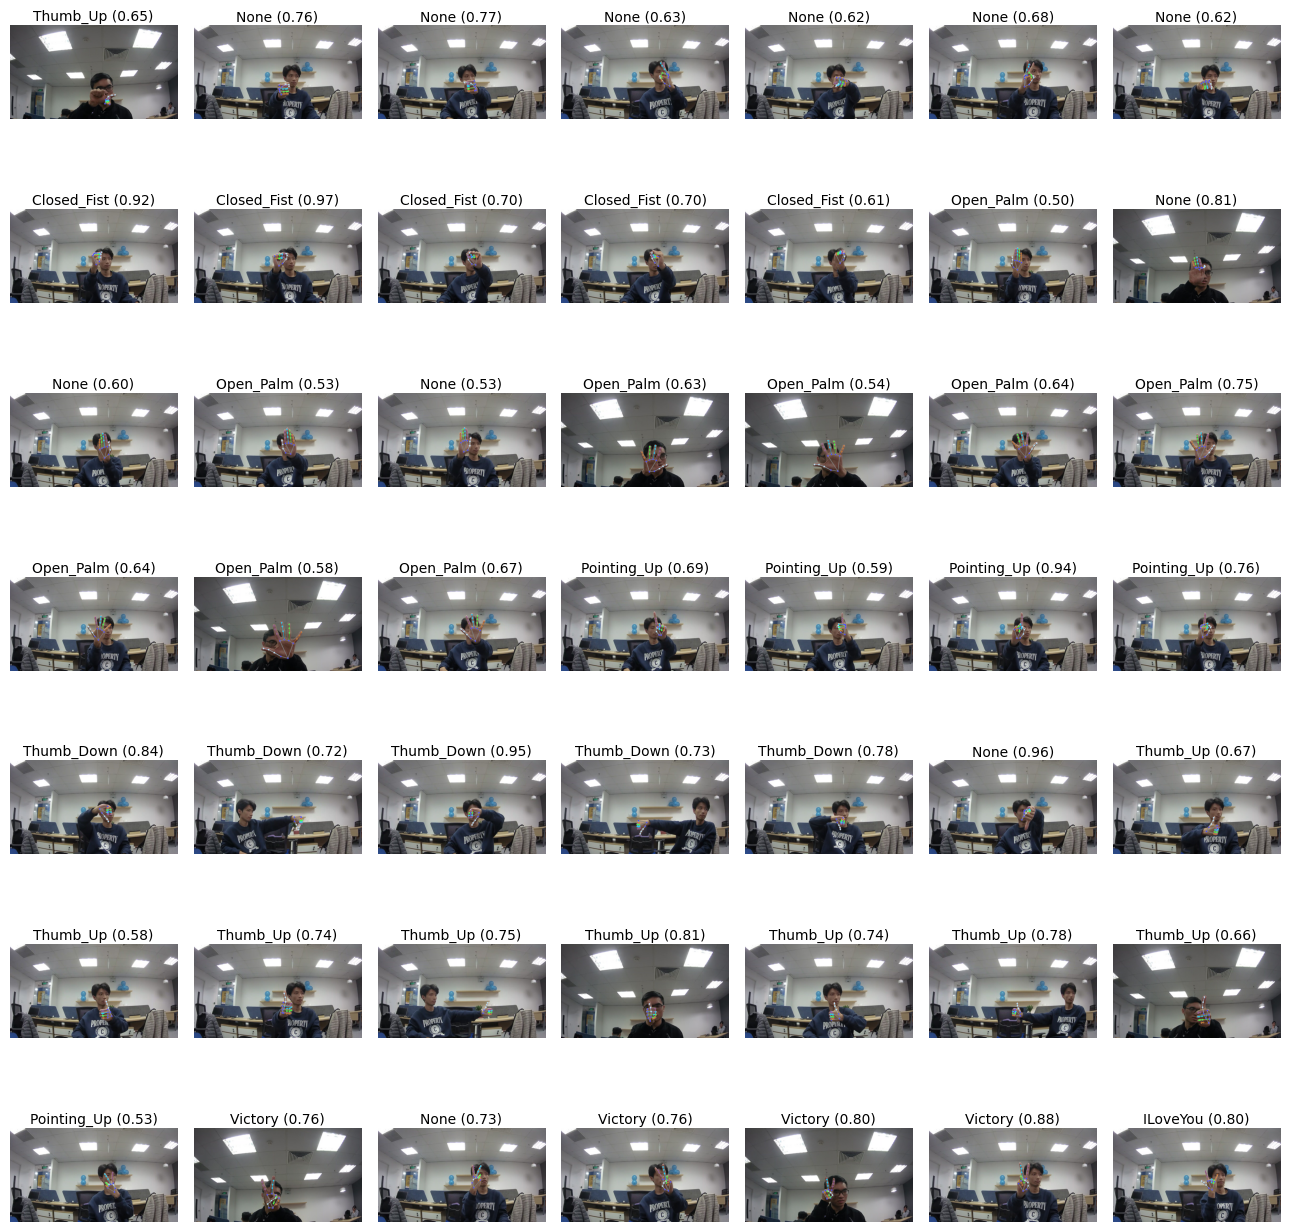

Number of images: 60, Number of undetected images: 7/60, Number of wrong label images: 8/53


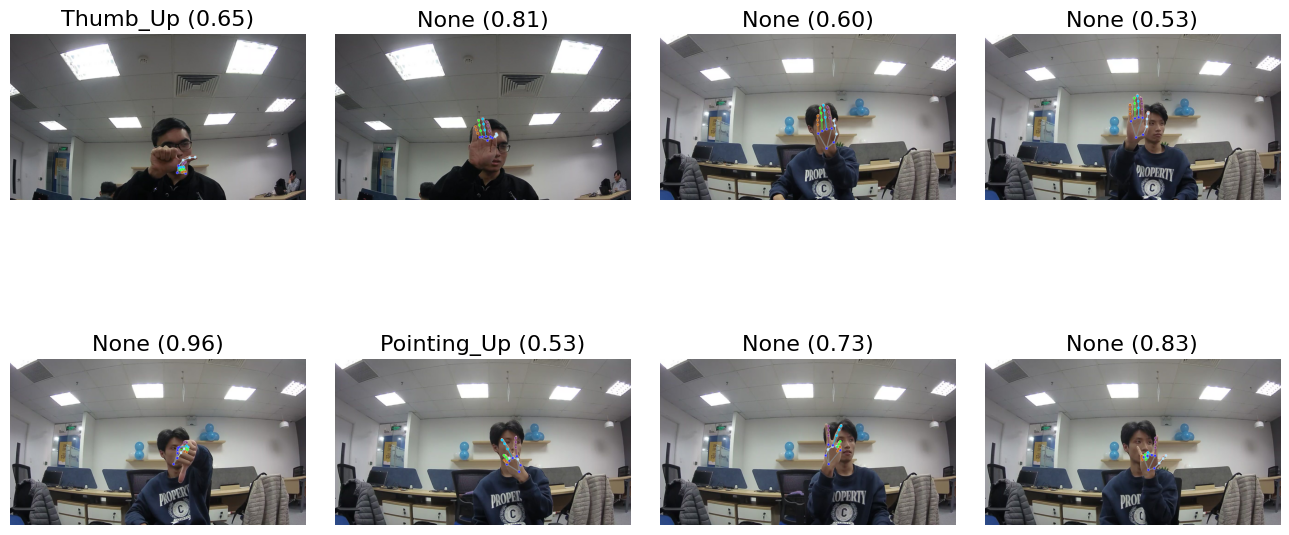

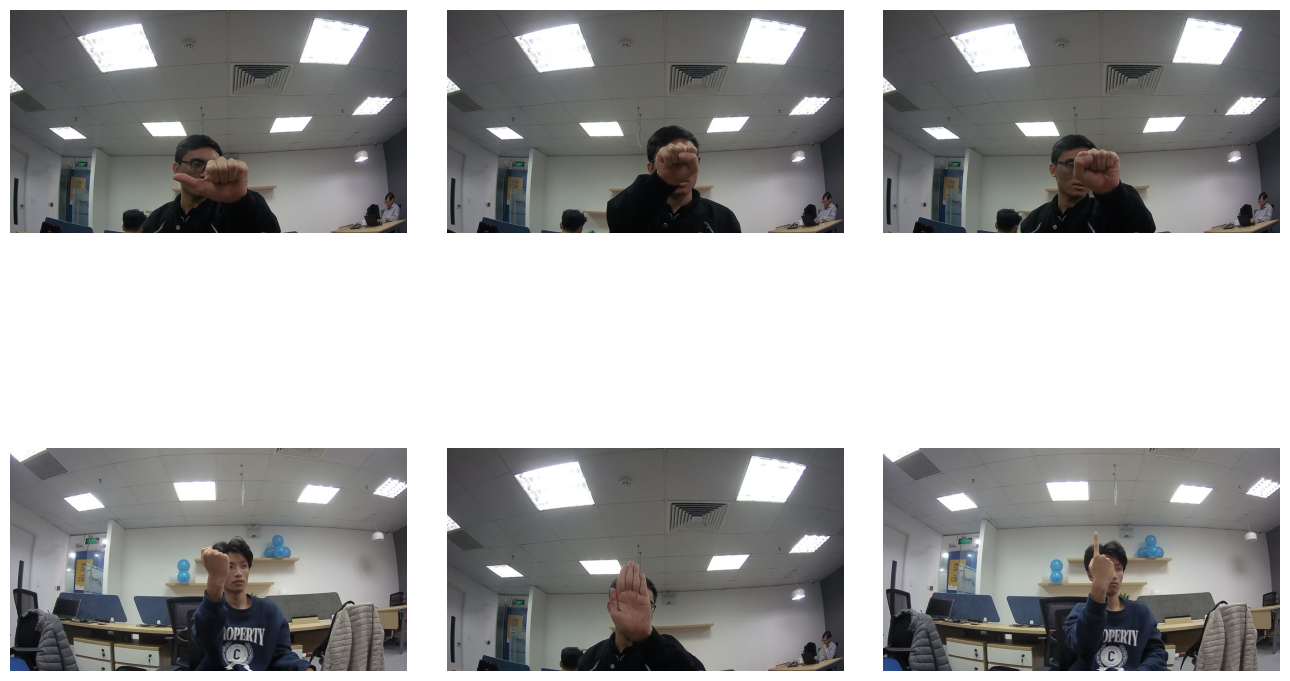

              precision    recall  f1-score   support

           0       0.50      0.86      0.63         7
           1       1.00      1.00      1.00         5
           2       1.00      0.75      0.86        12
           3       0.80      1.00      0.89         4
           4       1.00      0.83      0.91         6
           5       0.89      1.00      0.94         8
           6       1.00      0.67      0.80         6
           7       1.00      0.80      0.89         5

    accuracy                           0.85        53
   macro avg       0.90      0.86      0.86        53
weighted avg       0.90      0.85      0.86        53


In [24]:
# STEP 1: Import the necessary modules.
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision
from sklearn.metrics import classification_report

# STEP 2: Create an GestureRecognizer object.
base_options = python.BaseOptions(model_asset_path='gesture_recognizer.task')
options = vision.GestureRecognizerOptions(base_options=base_options, num_hands=1)
recognizer = vision.GestureRecognizer.create_from_options(options)

n_not_detected = 0
n_wrong_label = 0

images = []
results = []
idx = 0

img_not_detected = []
img_wrong_label = []
wrong_results = []

y_pred = []
y_true = []

log_images = []

for image_file_name in IMAGE_FILENAMES:
    # STEP 3: Load the input image.
    filename = './data/new/' + str(image_file_name['label']) + "/" + image_file_name['filename']
    image = mp.Image.create_from_file(filename)

    # STEP 4: Recognize gestures in the input image.
    recognition_result = recognizer.recognize(image)

    if len(recognition_result.gestures) == 0:
        img_not_detected.append(image)
        n_not_detected += 1

        log_images.append({
            "filename": image_file_name['filename'],
            "label": image_file_name['label'],
            "status": "Undetected"
        })

        continue
    else:
        # STEP 5: Process the result. In this case, visualize it.
        lb_str = recognition_result.gestures[0][0].category_name
        lb = params.LABELS[lb_str]
        y_pred.append(lb)
        y_true.append(image_file_name['label'])
        if lb != image_file_name['label']:
            img_wrong_label.append(image)
            top_gesture = recognition_result.gestures[0][0]
            hand_landmarks = recognition_result.hand_landmarks
            wrong_results.append((top_gesture, hand_landmarks))
            n_wrong_label += 1

            log_images.append({
                "filename": image_file_name['filename'],
                "label": image_file_name['label'],
                "status": "Wrong label"
            })

        images.append(image)
        top_gesture = recognition_result.gestures[0][0]
        hand_landmarks = recognition_result.hand_landmarks
        results.append((top_gesture, hand_landmarks))

display_batch_of_images_with_gestures_and_hand_landmarks(images, results)

create_log_file(log_images, filename=f'undetected_and_wrong_label_for_{len(IMAGE_FILENAMES)}')

print(
    f"Number of images: {total_images}, Number of undetected images: {n_not_detected}/{total_images}, Number of wrong label images: {n_wrong_label}/{total_images - n_not_detected}")

display_batch_of_images_with_gestures_and_hand_landmarks(img_wrong_label, wrong_results)
display_batch_of_images_undetected(img_not_detected)

print(classification_report(y_true, y_pred))